# **Autoencoders for hand-written digit recognition and sentiment analysis**

We will use the MNIST dataset containing handwritten digits images.
We will develop simple shallow and deep autoencoders and a denoising autoencoder. Then we will move to the sequential domains, considering the IMDB dataset which contains the text of some reviews and the sentiment (positive or negative) given by the authors of the reviews.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#### **MNIST Dataset loading and pre-processing**
The MNIST dataset contains 60,000 training images and 10,000 testing images.
Each value is between 0 and 255, and represents a pixel in an image of size 28 x 28. We will normalize all values between 0 and 1, and we will flatten the 28x28 images into vectors of size 784.
Finally, we will split the test set, in the test and validation set.

In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid = x_train[:10000]
x_train = x_train[10000:]

11493376/11490434 [==============================] - 0s 0us/step


## **Singular Value Decomposition (SVD)**

Principal component analysis (PCA) and singular value decomposition (SVD) are both classical linear dimensionality reduction methods that attempt to find linear combinations of features in the original high dimensional data matrix to construct a meaningful representation of the dataset.
In this first part of the HW we will focus our attention on SVD decomposition. Indeed it is more numerical stable. Given a matrix X, the SVD decomposes a matrix into the product of two unitary matrices V and U and a rectangular diagonal matrix of singular values S:

$$ X=V \cdot S \cdot U^T$$

SVD is implemented in NumPy as np.linalg.svd. In our case the X matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features).

Note that the X matrix, in our case, will have a huge number of rows (we have 50000 input samples) and only 784 columns. Therefore, to optimize the memory consumption we can compute the SVD of the covariance matrix. An interesting property of the SVD is that we can relate the decomposition of the covariance matrix $C= X^T \cdot X$ to the decomposition of $X$. In fact

$$ C= X^T \cdot X = U \cdot S \cdot V^T \cdot V\cdot S \cdot U^T  = U \cdot S^2 \cdot U^T$$

Since we need just the matrix U to compute the compressed version of our data, this method will be very convenient. If you are using the Colab free plan, the quantity of available ram is not sufficient to compute the SVD of X, therefore computing the SVD of the covariance matrix turns out to be the best solution. 

In [ ]:
def svd_k(X, k):
  # Covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k

#### **Data compression**

In [ ]:
ENCODING_DIM = 120 # size of the compressed version of input data

U_k = svd_k(x_train, ENCODING_DIM)
x_training_pca = np.dot(x_train, U_k)
x_test_pca = np.dot(x_test, U_k)

The parameter ENCODING_DIM defines the level of compression (approximization) of the dataset: the lower it is the more approximated the output will be. In particular this parameter indicates the number of the principal directions considered in order to compute the truncated $SVD$ decomposition: the resulting matrix $U$ will have a number of columns corresponding to ENCODING_DIM (the feasible maximum number of row is 784) and the same number of rows as X i.e. 784.
I reported in the following table the results obtained by varying the ENCODING_DIM:

> ENCODING_DIM | Training MSE | Test MSE | Description of the output image
> --- | --- | --- | ---
> 10 | 0.0346 | 0.0342 | very low quality, human eyes do not recognize the digit 
> 60 | 0.00994 | 0.00967 | low quality, but the digits are still recognizable
> 120 | 0.00464 | 0.00455 | good quality, a bit blurred
> 300 | 0.00093 | 0.00092 | high quality

In conclusion, by considering less than half of the total principal directions (300 out of 784) we are able to get a very low error both on the training and the test set and reduce the computational complexity and the memory consumption.

#### **Data reconstruction **

By reconstructing the input data we can check how much information was lost due to the compression: we visualize the reconstructed images and compute the mean squared error between the original input and the reconstruction.

In [ ]:
x_training_reco= np.dot(x_training_pca, U_k.T)
x_test_reco= np.dot(x_test_pca, U_k.T)

In [ ]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("training mse: %.5f" % ( accuracy_train))
print("test mse: %.5f" % ( accuracy_test))

training mse: 0.00464
test mse: 0.00455


In [ ]:
def plot_img(n, input_data, decoded_imgs):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(input_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

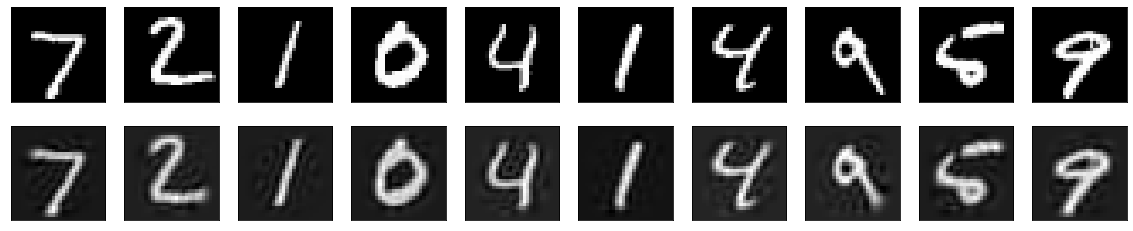

In [ ]:
plot_img(10, x_test, x_test_reco)

The first row of images shows input data, while the second one shows the reconstructions.

## **Shallow Linear Autoencoders**
The model consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively.


In [ ]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
# encoder
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)
# decoder
decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)
# autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 120)               94200     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0427 - val_loss: 0.0177
Epoch 2/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0120 - val_loss: 0.0088
Epoch 3/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0078 - val_loss: 0.0069
Epoch 4/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0065 - val_loss: 0.0060
Epoch 5/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 6/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 7/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 8/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 9/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 10/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 11/

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

313/313 - 0s - loss: 0.0048
test mse: 0.00476


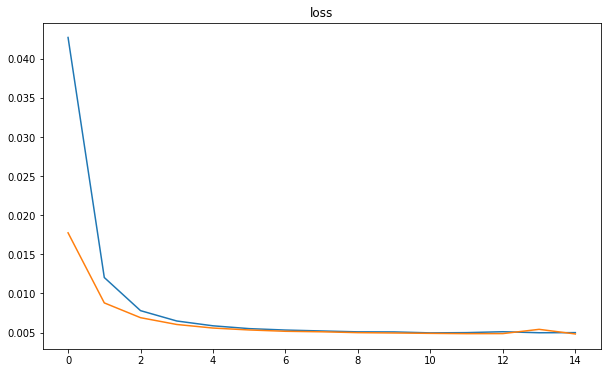

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

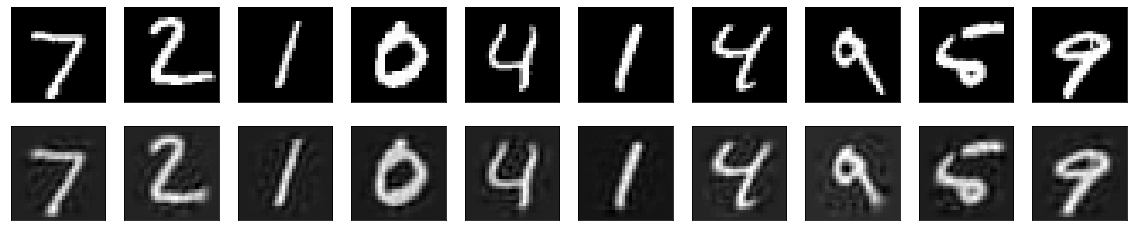

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)


#### **Discussion: the relationship between shallow linear Autoencoders and the SVD decomposition**

The Shallow Linear Autoencoder is an Undercomplete Autoencoder with one hidden layer: the number of input units is equal to the number of output units and higher than the number of hidden units. Therefore, this network is closely linked to PCA because every layer behaves as a linear projection: we first project the data onto the PCA subspace (input layer $\rightarrow$ hidden layer) and then we reconstruct the data from the PCA (hidden layer $\rightarrow$ output layer). In particular, the Principal Components are othogonal directions of maximum variance of data and they are computed by minimazing the average squared distance w.r.t. the points of the dataset. In our case, we measure the training and test errors by the Mean Squared Error, so we obtain roughly equal results as PCA!

In fact it can be mathematically proved that PCA has the Least Squared Error in reconstruction. In conclusion, after the training of the Shallow Linear Autoencoder by back-propagation, we obtain weights almost equal to PCA directions.

The relationship with SVD decomposition comes from the fact that it is the best way to compute the Principal Components: we collect all the data as rows in a matrix $X\in\mathbb{R}^{n\times m}$ which is decomposed as $X = VSU^{T}$ where $V\in\mathbb{R}^{n\times n}$ and $U\in\mathbb{R}^{m\times m}$ are orthonormal matrices whose columns are a basis for, respectively, the rows and the column of matrix $X$ and $S\in\mathbb{R}^{n\times m}$ is a non-negative diagonal matrix whose singular values are proportional to the importance of the rows of $U^{T}$. In particular the rows of $U^{T}$ give the Principal Components of the distribution of data in $X$.

So the reduced representation of $X$ is given by $XU=VSU^{T}U=VS$ and this operation is equivalent to project the rows of $X$ over the basis $U$ (input layer $\rightarrow$ hidden layer).

As a consequence, we have to multiply the matrix $XU$ by $U^{T}$ in order to reconstruct the data $X$ (hidden layer $\rightarrow$ output layer).

In this case, for computational and memory needs, we just consider some Principal Directions according to the value of ENCODING_DIM, so we obtain an approximate reconstruction of the data. Moreover we have $n>>m$ so we compute $SVD$ on the covariance matrix $C=X^{T}X\in \mathbb{R}^{m\times m}$: in this way we're able to calculate the matrix $U$ which is the only matrix needed.

In conclusion, computing SVD decomposition is the same as training the Shallow Linear Autoencoder and it is evident by considering our results: in the first case we obtained Test MSE = 0.00455 and in the second case we obtained an almost equal Test MSE = 0.00476.



##**Shallow Non-Linear Autoencoders**

Instead of using linear activation functions, we use non-linear ones.


In [ ]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
# encoder
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)
# decoder
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)
# autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

autoencoder.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 120)               94200     
_________________________________________________________________
dense_9 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0543 - val_loss: 0.0350
Epoch 2/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0285 - val_loss: 0.0228
Epoch 3/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0196 - val_loss: 0.0165
Epoch 4/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0147 - val_loss: 0.0129
Epoch 5/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0119 - val_loss: 0.0107
Epoch 6/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0100 - val_loss: 0.0092
Epoch 7/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0087 - val_loss: 0.0081
Epoch 8/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0076 - val_loss: 0.0072
Epoch 9/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0069 - val_loss: 0.0065
Epoch 10/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0063 - val_loss: 0.0060
Epoch 11/

313/313 - 0s - loss: 0.0043
test mse: 0.00432


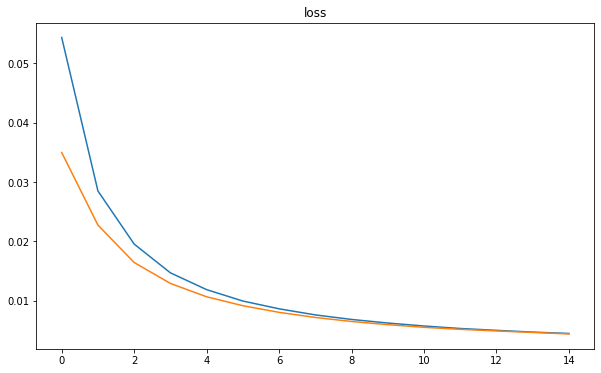

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

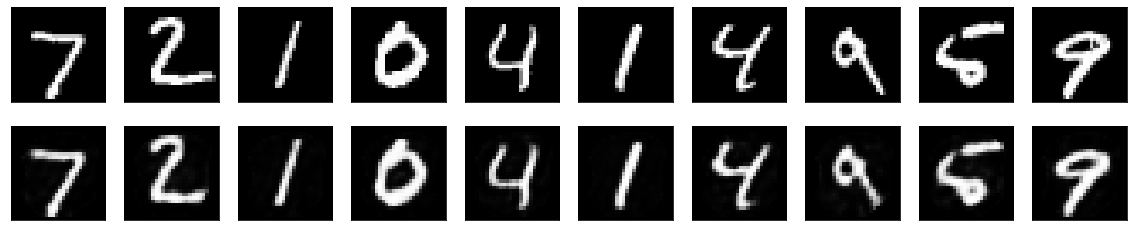

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)

#### **Discussion**

If the data is embdedded in a non-linaer manifold (subspace) a Non-Linear Autoencoder should work better on that dataset because it allows non-linear projections by using non-linear activation functions. In particular, our dataset is composed by vectors whose components take values in [0,1] and, since we want to reconstruct the input, it's better to choose for the decoder a bounded activation function like Sigmoid, which takes values in [0,1].

Moreover, Sigmoid seems the best non-linear activation function to be applied on both encoder and decoder: Test MSE = 0.00432 when applying 'sigmoid' on both encoder and decoder layers, which is a bit better result than Test MSE = 0.00476 obtained when applying 'linear' on both encoder and decoder layers.

I also tried to apply 'relu' (which takes values in [0,$+\infty$)) or 'tanh' (which takes values in [-1,1]) on the encoder and 'sigmoid' on the decoder, but I obtained worse results.

In conclusion, we aren't able to significantly improve the MSE loss with a non-linear activation function, because if the data is embdedded in a non-linaer manifold, then we want to minimize the 'geodesic' distance, which represents the shortest path between two points in a non-linear surface, while the algorithm we implemented minimizes the MSE which takes into account the euclidean distance. In fact for single-label multi-classes task it's better to use crossentropy loss function with sigmoid activation function on the last layer.

On the other hand, we can easily observe that the input image recostrution of the Linear Autoencoder is worse than the reconstruction of the Non-Linear Autoencoder (by using the same value of ENCODING_DIM = 120): in the linear case the image in output is a bit faded and blurred compared with the image in input, but in the non-linear case the image in output has a higher quality and is pretty similar to the image in input.


## **Deep Autoencoders**
The model will use $n$ layers for encoding, and $n-1$ for decoding. The layers sizes of the encoding part decrease at each layer, while the decoding part layers dimensions progression turns out to be mirrored.


In [ ]:
ENCODING_DIM = 32

# n = 4 layers for encoding:
input_img = tf.keras.layers.Input(shape=(784,))
encoded = tf.keras.layers.Dense(128, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='relu')(encoded)

# n-1 = 3 'mirrored' layers for decoding:
decoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(128, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = tf.keras.models.Model(input_img, decoded)

encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-3]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')

autoencoder.summary()

Model: "model_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_122 (Dense)            (None, 128)               100480    
_________________________________________________________________
dense_123 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_124 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_125 (Dense)            (None, 64)                2112      
_________________________________________________________________
dense_126 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_127 (Dense)            (None, 784)               101

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/50
196/196 [==============================] - 3s 16ms/step - loss: 0.2583 - val_loss: 0.1740
Epoch 2/50
196/196 [==============================] - 3s 16ms/step - loss: 0.1572 - val_loss: 0.1445
Epoch 3/50
196/196 [==============================] - 3s 16ms/step - loss: 0.1389 - val_loss: 0.1315
Epoch 4/50
196/196 [==============================] - 3s 16ms/step - loss: 0.1278 - val_loss: 0.1231
Epoch 5/50
196/196 [==============================] - 3s 16ms/step - loss: 0.1211 - val_loss: 0.1176
Epoch 6/50
196/196 [==============================] - 3s 16ms/step - loss: 0.1162 - val_loss: 0.1133
Epoch 7/50
196/196 [==============================] - 3s 16ms/step - loss: 0.1125 - val_loss: 0.1108
Epoch 8/50
196/196 [==============================] - 3s 16ms/step - loss: 0.1096 - val_loss: 0.1079
Epoch 9/50
196/196 [==============================] - 3s 16ms/step - loss: 0.1075 - val_loss: 0.1058
Epoch 10/50
196/196 [==============================] - 3s 16ms/step - loss: 0.1056 - val_lo

313/313 - 1s - loss: 0.0852
test mse: 0.08522


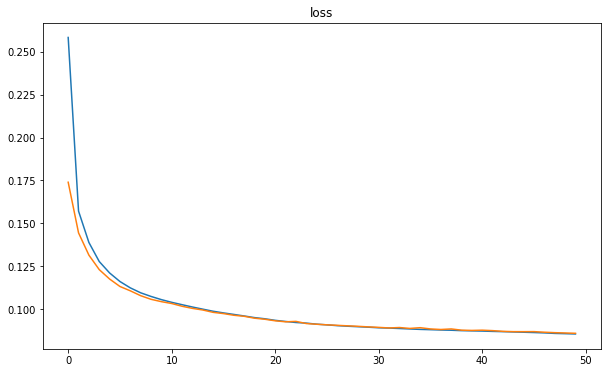

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

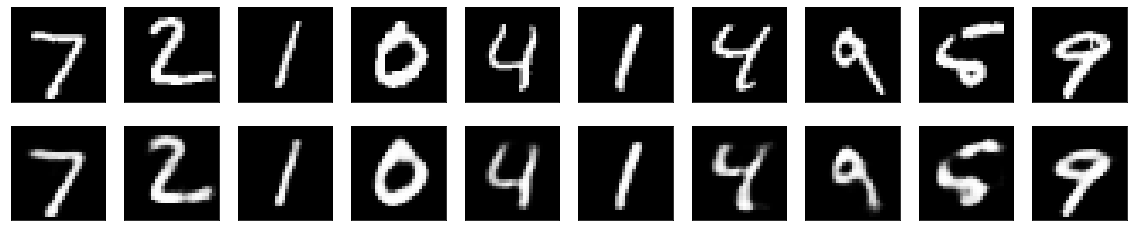

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, x_test, decoded_imgs)


## ** Denoising Autoencoder**

We define a noise factor that can be used to modify the amount of noise to add to the input data, and to check how much it influences the denoising capability of the autoencoder.

In [ ]:
# Noise injection in the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000],y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

noise_factor = 0.3

x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

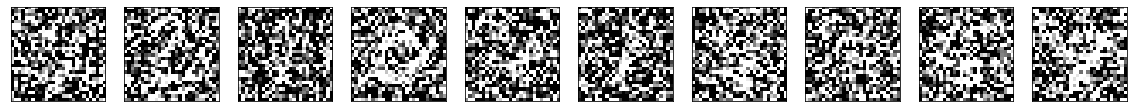

In [ ]:
# Some noisy examples
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
ENCODING_DIM = 32

# n = 4 layers for encoding:
input_img = tf.keras.layers.Input(shape=(784,))
encoded = tf.keras.layers.Dense(128, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='relu')(encoded)

# n-1 = 3 'mirrored' layers for decoding:
decoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(128, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = tf.keras.models.Model(input_img, decoded)

encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-3]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')

autoencoder.summary()

Model: "model_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_128 (Dense)            (None, 128)               100480    
_________________________________________________________________
dense_129 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_130 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_131 (Dense)            (None, 64)                2112      
_________________________________________________________________
dense_132 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_133 (Dense)            (None, 784)               101

In [ ]:
history = autoencoder.fit(x_train_noisy, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/50
196/196 [==============================] - 3s 17ms/step - loss: 0.2831 - val_loss: 0.3728
Epoch 2/50
196/196 [==============================] - 4s 21ms/step - loss: 0.2381 - val_loss: 0.2988
Epoch 3/50
196/196 [==============================] - 6s 29ms/step - loss: 0.2176 - val_loss: 0.2444
Epoch 4/50
196/196 [==============================] - 5s 25ms/step - loss: 0.2059 - val_loss: 0.2157
Epoch 5/50
196/196 [==============================] - 3s 16ms/step - loss: 0.1972 - val_loss: 0.2017
Epoch 6/50
196/196 [==============================] - 3s 16ms/step - loss: 0.1929 - val_loss: 0.1978
Epoch 7/50
196/196 [==============================] - 3s 16ms/step - loss: 0.1903 - val_loss: 0.1914
Epoch 8/50
196/196 [==============================] - 3s 16ms/step - loss: 0.1879 - val_loss: 0.1926
Epoch 9/50
196/196 [==============================] - 3s 16ms/step - loss: 0.1858 - val_loss: 0.1881
Epoch 10/50
196/196 [==============================] - 3s 17ms/step - loss: 0.1839 - val_lo

313/313 - 1s - loss: 0.1680
test mse: 0.16804


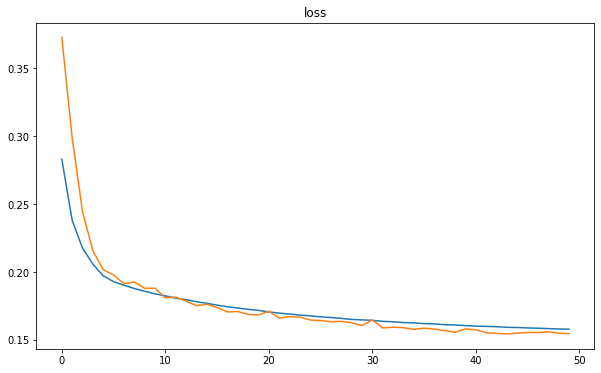

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("test mse: %.5f" % (scores))

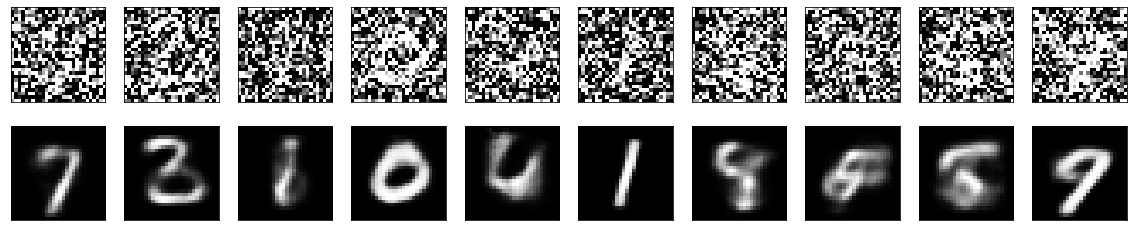

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, x_test_noisy, decoded_imgs)

## **Autoencoders for Sequences**

In this case, as dataset, we will use the IMDB dataset. To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in Colab), we will limit the number of training samples and test samples.

#### **IMDB Dataset loading and pre-processing**

In [ ]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by the IMDB dataset loader, we use the to_categorical method to transform them in the correspondent one-hot representations.

In [ ]:
from keras.utils import to_categorical

X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)

#### **Linear Autoencoder**

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

Since the output will be a one-hot representation, we used binary crossentropy as loss function and  categorical accuracy as metric.

In [ ]:
sequence_autoencoder.summary()

Model: "model_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 90, 50)            7550      
_________________________________________________________________
time_distributed_8 (TimeDist (None, 90, 100)           5100      
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 6s 77ms/step - loss: 0.1904 - categorical_accuracy: 0.1855 - val_loss: 0.0902 - val_categorical_accuracy: 0.4221
Epoch 2/50
79/79 [==============================] - 6s 74ms/step - loss: 0.0734 - categorical_accuracy: 0.4565 - val_loss: 0.0654 - val_categorical_accuracy: 0.4802
Epoch 3/50
79/79 [==============================] - 6s 75ms/step - loss: 0.0600 - categorical_accuracy: 0.5127 - val_loss: 0.0581 - val_categorical_accuracy: 0.5408
Epoch 4/50
79/79 [==============================] - 6s 76ms/step - loss: 0.0540 - categorical_accuracy: 0.5559 - val_loss: 0.0525 - val_categorical_accuracy: 0.5583
Epoch 5/50
79/79 [==============================] - 6s 73ms/step - loss: 0.0489 - categorical_accuracy: 0.5785 - val_loss: 0.0475 - val_categorical_accuracy: 0.5813
Epoch 6/50
79/79 [==============================] - 6s 75ms/step - loss: 0.0444 - categorical_accuracy: 0.6043 - val_loss: 0.0431 - val_categorical_accuracy: 0.6084
Epoch 7/50

40/40 - 0s - loss: 0.0111 - categorical_accuracy: 0.9387
categorical_accuracy: 93.87%


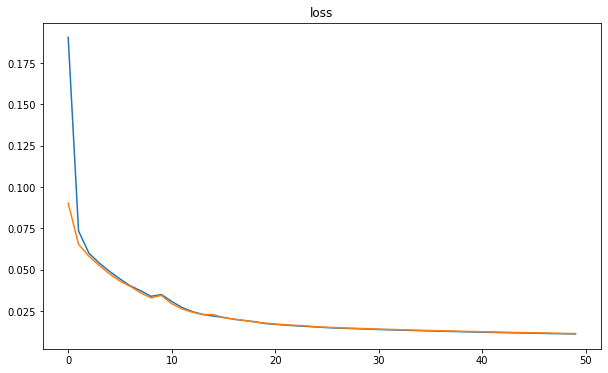

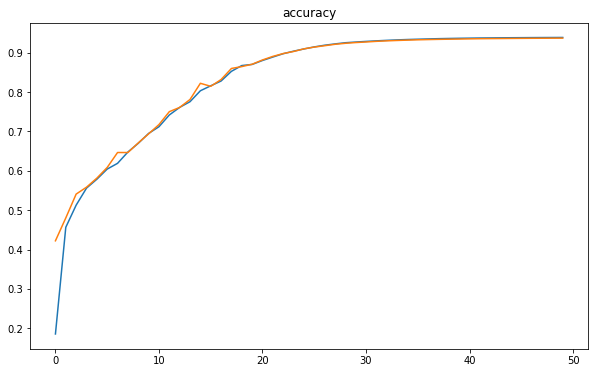

In [ ]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
# Example
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
is a <oov> <oov> that to <oov> in <oov> of that time in that <oov> the <oov> is <oov> a even <oov> film in just no <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film is <oov> <oov> there <oov> other <oov> <oov> <oov> of <oov> <oov> in the <oov> <oov> this is a really of film that <oov> <oov> <oov> on is <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> <oov> <oov>


#### **Non-Linear Autoencoder**

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(16, return_sequences=True, activation='tanh')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

In [ ]:
sequence_autoencoder.summary()

Model: "model_109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_70 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 90, 16)            7488      
_________________________________________________________________
time_distributed_14 (TimeDis (None, 90, 100)           1700      
Total params: 9,188
Trainable params: 9,188
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 8s 95ms/step - loss: 0.0512 - categorical_accuracy: 0.3770 - val_loss: 0.0429 - val_categorical_accuracy: 0.4614
Epoch 2/50
79/79 [==============================] - 7s 85ms/step - loss: 0.0385 - categorical_accuracy: 0.4710 - val_loss: 0.0374 - val_categorical_accuracy: 0.4614
Epoch 3/50
79/79 [==============================] - 7s 86ms/step - loss: 0.0366 - categorical_accuracy: 0.4710 - val_loss: 0.0367 - val_categorical_accuracy: 0.4614
Epoch 4/50
79/79 [==============================] - 7s 85ms/step - loss: 0.0356 - categorical_accuracy: 0.4710 - val_loss: 0.0353 - val_categorical_accuracy: 0.4614
Epoch 5/50
79/79 [==============================] - 7s 87ms/step - loss: 0.0340 - categorical_accuracy: 0.4710 - val_loss: 0.0334 - val_categorical_accuracy: 0.4614
Epoch 6/50
79/79 [==============================] - 7s 85ms/step - loss: 0.0320 - categorical_accuracy: 0.4710 - val_loss: 0.0314 - val_categorical_accuracy: 0.4614
Epoch 7/50

40/40 - 1s - loss: 4.5805e-04 - categorical_accuracy: 1.0000
categorical_accuracy: 100.00%


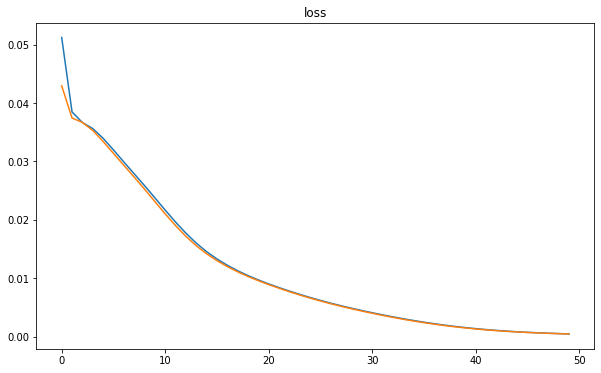

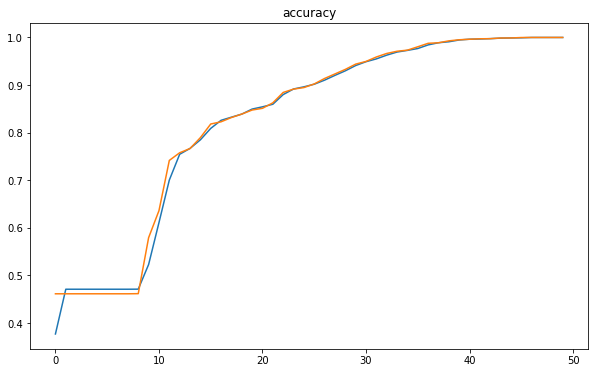

In [ ]:
plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
# Example
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


#### **Discussion**

In order to make a fair comparison between the two models, I set the number of LSTM units equal to 16: I obtained 7488 parameters, while the number of parameters of the Simple RNN with 50 units is 7550.

Each sample in the Training and Test set is a tensor with 90 rows each of which contains a vector of length 100 with all components equal to zero, except one equal to 1. This means that we have sequences made of 90 words each of which is one-hot encoded (the non-zero component refers to the correct category to which the word belongs). For this reason I set 'softmax' as activation function for the last dense layer: it takes values in [0,1] and the components of the vector representing a word all sum up to 1, so this can be interpretated as a probability distribution. As a consequence the component with the highest value (highest probability) will be predected as 1 and all the other components as 0.

Moreover I set 'tanh' as activation function for the LSTM because it is the most common used activation function; in fact the activation function for the three gates is always the Sigmoid, while the activation function for the input and the output is usually the Hyperbolic Tangent, which seems to work well in practice: it is a bounded smooth function which takes values in [-1,1] so it is able to change the sign of the state values, unlike Sigmoid whose output is always non-negative so values in the state would never be negative; moreover the first order derivative of Hyperbolic Tangent is $\frac{\partial}{\partial z}tanh(z) = 1 - tanh^{2}(z)$ so the gradient is not so computationally expensive and, consequently, the training is usually fast; moreover it has a steeper slope than sigmoid and its derivative takes values in [0,1] so it's generally bigger (the gradient is 'stronger' i.e. gradient vanishing is better handled) than the one of sigmoid which takes values in $[0,\frac{1}{4}]$.

This model was able to reach 100% of accuracy while the Linear Autoencoder implemented with Simple RNN got 93.87% of accuracy. In fact LSTM architecture allows the network to "remember" relevant information for a long period of time thanks to the Linear Memory Cell that integrates input information through time; in fact LSTM is an extension of the Simple RNN that deals with long-term temporal dependencies, managed - during learning, not a priori - by the input gate (let input flow in the memory cell), the output gate (let the stored current value to be read in output) and the forget gate (let the stored current value to be reset to 0). So by using LSTM units in the decoder, we give a bit more information to the decoder in order to make the learning task easier. Unlike the Simple RNN, LSTM needs an output activation function (in this case 'tanh'), otherwise we'll have an explosion in the value of the output. 